In [48]:
import numpy as np
import pandas as pd
import urllib3
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib import rcParams
warnings.filterwarnings('ignore')
%matplotlib inline

# It's Always Sunny in Philadelphia analysis

Hitting Open IMDB API for data about IASIP

## 1. Data Acquisition

Specifiy API parameters then loop through the episodes to build a data set

In [2]:
# HTTP parameters
user = 'xxxx'
password = 'xxxx'
proxy_ip = 'xxxx'
default_headers = urllib3.make_headers(proxy_basic_auth='user:password')
http = urllib3.ProxyManager("proxy_ip", headers=default_headers)

# Template API to call
template_api = 'https://www.omdbapi.com/?t={tv_show}&Season={season}&Episode={episode}&apikey={api_key}'

# Inputs to complete the API with
input_dict = {   
    'api_key': '33b32b36',
    'tv_show': 'It\'s+Always+Sunny+in+Philadelphia'
}

# Season range
seasons = np.arange(1, 13, 1)
episodes = np.arange(1, 16, 1)

In [3]:
# Loop through all seasons and episodes to generate the data
i = 0
for season in seasons:
    
    for episode in episodes:
        
        # Complete the api template with the inputs and current season/episode
        api = template_api.format(**input_dict, episode=episode, season=season)
        r = http.request('GET', api)
        
        # If this season/epsiode combo doesn't exist, skip
        if 'Series or episode not found' in str(r.data):
            continue
        
        # Append the data to a master dataframe
        if i == 0:
            df = pd.DataFrame(json.loads(r.data.decode('utf-8')))
        else:
            df = pd.concat([df, pd.DataFrame(json.loads(r.data.decode('utf-8')))], axis=0)
        
        # Counter solely to instantiate dataframe on first loop
        i += 1

In [8]:
df.to_csv('IASIP_episode_data.csv', index=False)
df.head()

,Title,Year,Rated,Released,Season,Episode,Runtime,Genre,Director,Writer,...,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,seriesID,Type,Response
0,The Gang Gets Racist,2005,TV-MA,04 Aug 2005,1,1,22 min,Comedy,John Fortenberry,"Rob McElhenney (developer), Glenn Howerton (de...",...,N/A,https://images-na.ssl-images-amazon.com/images...,"{'Source': 'Internet Movie Database', 'Value':...",N/A,8.3,2042,tt0612823,tt0472954,episode,True
0,Charlie Wants an Abortion,2005,TV-MA,11 Aug 2005,1,2,22 min,Comedy,John Fortenberry,"Rob McElhenney (developer), Glenn Howerton (de...",...,N/A,https://images-na.ssl-images-amazon.com/images...,"{'Source': 'Internet Movie Database', 'Value':...",N/A,8.4,1641,tt0612820,tt0472954,episode,True
0,Underage Drinking: A National Concern,2005,TV-MA,16 Aug 2005,1,3,22 min,Comedy,Daniel Attias,"Rob McElhenney (developer), Glenn Howerton (de...",...,N/A,http://ia.media-imdb.com/images/M/MV5BNTQyODQw...,"{'Source': 'Internet Movie Database', 'Value':...",N/A,8.5,1447,tt0612824,tt0472954,episode,True
0,Charlie Has Cancer,2005,TV-MA,23 Aug 2005,1,4,23 min,Comedy,Rob McElhenney,"Rob McElhenney (developer), Glenn Howerton (de...",...,N/A,https://ia.media-imdb.com/images/M/MV5BMTUwMzM...,"{'Source': 'Internet Movie Database', 'Value':...",N/A,8.2,1668,tt0612819,tt0472954,episode,True
0,Gun Fever,2005,TV-MA,30 Aug 2005,1,5,21 min,Comedy,Daniel Attias,"Rob McElhenney (developer), Glenn Howerton (de...",...,N/A,https://images-na.ssl-images-amazon.com/images...,"{'Source': 'Internet Movie Database', 'Value':...",N/A,8.2,1416,tt0612822,tt0472954,episode,True


## 2. Visualisations

In [217]:
# Refresh main dataframe
df = pd.read_csv('IASIP_episode_data.csv')

### Total credits by writer

In [218]:
# Get a list of all the unique writers in 
unique_writers = []
for writer_record in df['Writer'].str.split(','):
    for writer in writer_record:
        
        # Exclude 'developer' and 'creator' credits
        if writer not in unique_writers and '(' not in writer:
            unique_writers.append(writer)
            
print(unique_writers[:10])

[' Charlie Day', ' Rob McElhenney', ' Glenn Howerton', ' Eric Falconer', ' Chris Romano', ' David Hornsby', ' Scott Marder', ' Rob Rosell', ' Jordan Young', ' Elijah Aron']


In [219]:
# Create columns detailing if a given writer is credited per episode

# For each writer...
for writer in unique_writers:
    
    writer_col_name = writer + ' credited flag'
    writers_credits = []
    
    # Go through every epsiode, breaking the credited writers into a list
    for entry in df['Writer'].str.split(','):
        
        present_in_entry = False
        
        # See if the current writer is present in this credited list
        for credited_writer in entry:
            if writer == credited_writer:
                present_in_entry = True
                break
                
        # Record whether they were present or not
        writers_credits.append(present_in_entry)
        
    # Save as a column in the dataframe
    df.loc[:, writer_col_name] = writers_credits

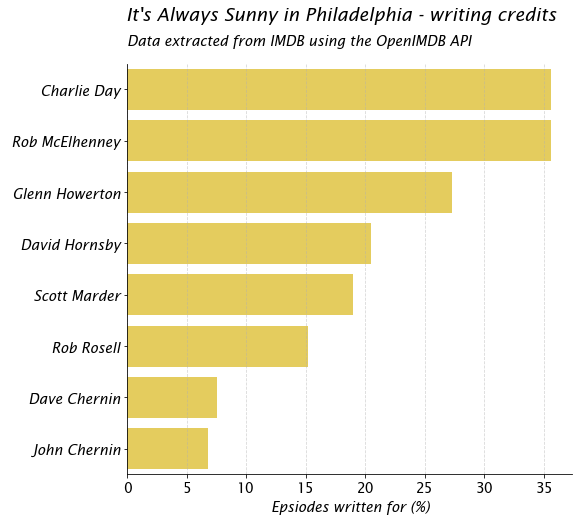

In [221]:
# Sum the credits to find biggest contributors
credit_mask = ['credited flag' in col for col in df.columns]
credit_cols = df.columns[credit_mask]
writer_credit_sums = 100 * df[credit_cols].sum().sort_values(ascending=False) / len(df)

# Only consider those credited with at least 5% of epsidoes
writer_credit_sums = writer_credit_sums[writer_credit_sums >= 5]
top_writer_cols = writer_credit_sums.index

# Plot
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Lucida Sans']
rcParams['font.style'] = 'italic'

fig, ax = plt.subplots(1, 1, figsize=[10, 8])
sns.barplot(
    x=writer_credit_sums, 
    y=writer_credit_sums.index.str[:-len(' credited flag')], 
    ax=ax,
    color='#FADA48'
)

# Format plot
ax.set_xlabel('Epsiodes written for (%)')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontstyle('normal')
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='x', linestyle='--', alpha=.5)

plt.suptitle('It\'s Always Sunny in Philadelphia - writing credits', fontsize=18, horizontalalignment='left', x=.18, y=0.9)
plt.title('Data extracted from IMDB using the OpenIMDB API', fontsize=14, horizontalalignment='left', x=0, y=1.03)
plt.tight_layout()
fig.subplots_adjust(right=0.8, top=0.8)
fig.savefig('writing_credit_perc.png')
plt.show()

### Credits by season by writer

In [202]:
# Sum by season
season_credits = df.groupby('Season')[top_writer_cols[:6]].sum()
season_credits.columns = [col[:-len(' credited flag')] for col in season_credits.columns]

# Convert to percentage (Rob McElhenney wrote them all)
season_credits = 100 * season_credits.divide(season_credits[' Rob McElhenney'], axis=0)
# season_credits.reset_index().melt(id_vars='Season', var_name='Writer', value_name='Credit percentage')

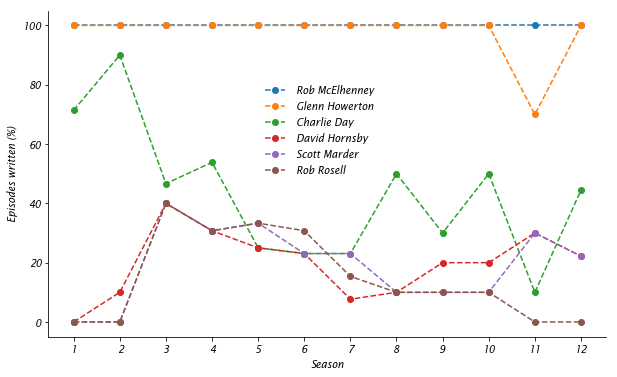

In [203]:
fig, ax = plt.subplots(1, 1, figsize=[10, 6])

for col in season_credits.columns:
    ax.plot(season_credits.index, season_credits[col], label=col, marker='o', linestyle='--')

ax.set_xticks(season_credits.index)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Season')
ax.set_ylabel('Episodes written (%)')

ax.legend(frameon=False, loc='upper right', bbox_to_anchor=(0.6, 0.8))
plt.show()